In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
import matplotlib.pyplot as plt
import seaborn as sb

# Verificar que la GPU está disponible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU disponible.")
else:
    print("GPU no disponible.")


GPU no disponible.


In [2]:
# Crear la carpeta 'resultados' si no existe
if not os.path.exists('resultados'):
    os.makedirs('resultados')

In [3]:
# Cargar los datos
cleaned_data_path = '../datasets/cleaned_data.csv'
data_all = pd.read_csv(cleaned_data_path)

C:\Users\Ketbome\AppData\Local\Temp\ipykernel_17840\909222528.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data_all = pd.read_csv(cleaned_data_path)


In [4]:
data_all.head()

ï»¿AGNO  RBD  DGV_RBD                  NOM_RBD  COD_REG_RBD NOM_REG_RBD_A  \
0     2022    1        9  LICEO POLITECNICO ARICA           15           AYP   
1     2022    1        9  LICEO POLITECNICO ARICA           15           AYP   
2     2022    1        9  LICEO POLITECNICO ARICA           15           AYP   
3     2022    1        9  LICEO POLITECNICO ARICA           15           AYP   
4     2022    1        9  LICEO POLITECNICO ARICA           15           AYP   

   COD_PRO_RBD  COD_COM_RBD NOM_COM_RBD  COD_DEPROV_RBD  ... COD_COM_ALU  \
0          151        15101       ARICA             151  ...       15101   
1          151        15101       ARICA             151  ...       15101   
2          151        15101       ARICA             151  ...       15101   
3          151        15101       ARICA             151  ...       15101   
4          151        15101       ARICA             151  ...       15101   

   NOM_COM_ALU  COD_RAMA  COD_SEC  COD_ESPE  PROM_GRAL  ASISTENCIA  SIT_FIN  \
0        ARICA       400      410     41001        6.6          98        P   
1        ARICA       400      410     41001        6.2          85        P   
2        ARICA       400      410     41001        6.3          86        P   
3        ARICA       400      410     41001        6.3         100        P   
4        ARICA       400      410     41001        6.7         100        P   

  SIT_FIN_R  COD_MEN  
0         P        0  
1         P        0  
2         P        0  
3         P        0  
4         P        0  

[5 rows x 37 columns]

In [5]:
# Cargar los datos
cleaned_data_path = '../datasets/cleaned_data.csv'
data_all = pd.read_csv(cleaned_data_path)

# Convertir la columna a números, los valores inválidos se convierten en NaN
data_all['EDAD_ALU'] = pd.to_numeric(data_all['EDAD_ALU'], errors='coerce')

# Eliminar las filas con NaN en la columna 'EDAD_ALU'
data_all = data_all.dropna(subset=['EDAD_ALU'])

# Borrar las filas donde la columna 'COD_SEC' sea distinto de 0
data_all = data_all[data_all['COD_SEC'] == 0]  # Solo alumnos de basica y media

# Eliminar la columna 'COD_ENSE'
data_all = data_all.drop(columns=['COD_ENSE'])

# Observar correlacion para hacer mas limpieza
numeric_columns = data_all.select_dtypes(include=np.number).columns
correlacion_all = data_all[numeric_columns].corr()

# Ver correlacion en base a valor a evaluar
correlacion_prom_gral = correlacion_all["PROM_GRAL"].sort_values(
    ascending=False)

# Obtén los nombres de las columnas con correlación mayor a 0.1
columnas_mayor_0_1 = correlacion_prom_gral[correlacion_prom_gral > 0.057].index

# Obtén los nombres de las columnas con correlación menor a -0.1
columnas_menor_neg_0_1 = correlacion_prom_gral[correlacion_prom_gral < -0.05].index

columnas_seleccionadas = columnas_mayor_0_1.tolist() + \
    columnas_menor_neg_0_1.tolist()

# Agregar comuna del colegio
columnas_seleccionadas.append('COD_COM_RBD')
# columnas_seleccionadas.append('DGV_RBD')

# Hacer data = data_all con las columnas a usar EDAD_ALU, GEN_ALU, PROM_GRAL
data_clear = data_all[columnas_seleccionadas]
data = data_clear.drop('FEC_NAC_ALU', axis=1)
data = data.drop('COD_GRADO', axis=1)

C:\Users\Ketbome\AppData\Local\Temp\ipykernel_17840\3891031790.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data_all = pd.read_csv(cleaned_data_path)


<Axes: >

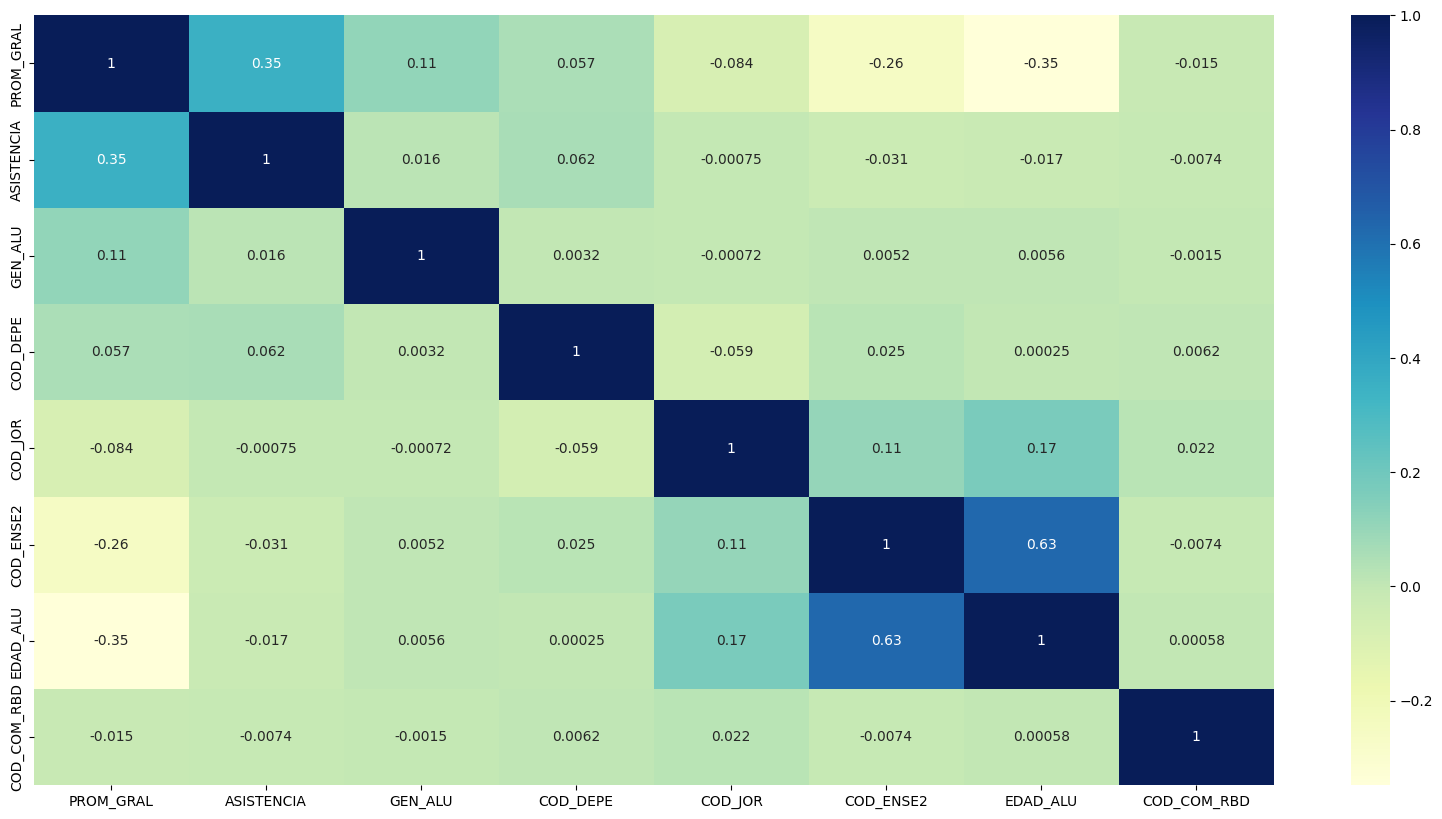

In [6]:
#Observar correlacion para hacer mas limpieza
plt.figure(figsize=(20,10))
sb.heatmap(data.corr(), annot=True, cmap='YlGnBu')


In [7]:
# Ver correlacion en base a valor a evaluar
data.corr()["PROM_GRAL"].sort_values(ascending=False)

PROM_GRAL      1.000000
ASISTENCIA     0.353526
GEN_ALU        0.113676
COD_DEPE       0.057404
COD_COM_RBD   -0.015470
COD_JOR       -0.084066
COD_ENSE2     -0.257659
EDAD_ALU      -0.348045
Name: PROM_GRAL, dtype: float64

In [8]:
# Saber cuantas filas hay y columnas
pd.DataFrame([data.shape], columns=['Filas', 'Columnas'])

Filas  Columnas
0  2929038         8

In [9]:
# División de datos
X = data.drop(columns=['PROM_GRAL'])
y = data['PROM_GRAL']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Ajustar y transformar
X_test_scaled = scaler.transform(X_test) # Solo transformar

In [48]:
model = keras.Sequential([
    layers.Dense(X_train_scaled.shape[1], activation='relu', input_shape=[X_train_scaled.shape[1]]),
    layers.Dense(36, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='gelu')
])

In [49]:
learning_rate = 0.001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse', # todos los tipos de pérdida: https://keras.io/api/losses/
    metrics=['mae'] # todas las métricas: https://keras.io/api/metrics/],
)

In [50]:
# Entrenamiento
model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=1024,
    verbose=1
)

Epoch 1/20
1831/1831 [==============================] - 6s 2ms/step - loss: 2.8729 - mae: 1.1155 - val_loss: 0.3563 - val_mae: 0.4577
Epoch 2/20
1831/1831 [==============================] - 4s 2ms/step - loss: 0.7212 - mae: 0.6672 - val_loss: 0.3389 - val_mae: 0.4484
Epoch 3/20
1831/1831 [==============================] - 4s 2ms/step - loss: 0.6442 - mae: 0.6294 - val_loss: 0.3344 - val_mae: 0.4460
Epoch 4/20
1831/1831 [==============================] - 4s 2ms/step - loss: 0.5432 - mae: 0.5755 - val_loss: 0.3281 - val_mae: 0.4393
Epoch 5/20
1831/1831 [==============================] - 4s 2ms/step - loss: 0.4442 - mae: 0.5169 - val_loss: 0.3251 - val_mae: 0.4353
Epoch 6/20
1831/1831 [==============================] - 4s 2ms/step - loss: 0.3751 - mae: 0.4716 - val_loss: 0.3239 - val_mae: 0.4353
Epoch 7/20
1831/1831 [==============================] - 4s 2ms/step - loss: 0.3404 - mae: 0.4465 - val_loss: 0.3226 - val_mae: 0.4319
Epoch 8/20
1831/1831 [==============================] - 4s 2ms

In [35]:
# Hacer una predicción
predicciones = model.predict(X_test_scaled)

18307/18307 [==============================] - 18s 988us/step


In [36]:
# aproximar a 1 decimal
predicciones = np.round(predicciones, 1)

In [37]:
print(f"Prediccion: {predicciones[6]}, Real: {y_test.iloc[6]}")

Prediccion: [1.], Real: 6.3


In [38]:
# Calcular el error absoluto medio
mae = mean_absolute_error(y_test, predicciones)
print('MAE: %.3f' % mae)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, predicciones)
print('MSE: %.3f' % mse)

# Calcular el coeficiente de determinación
r2 = r2_score(y_test, predicciones)
print('R2: %.3f' % r2)

MAE: 5.034
MSE: 25.809
R2: -53.633


In [18]:
# Guardar el modelo
model.save("./models/RedNeuronal4.h5")
# Guardar el modelo
model.save("./models/nn_model4")

INFO:tensorflow:Assets written to: ./models/nn_model4\assets


INFO:tensorflow:Assets written to: ./models/nn_model4\assets


In [19]:
# Guardar los resultados
results = pd.DataFrame({'Modelo': ['Neural Network'],
                        'MSE': [mse],
                        'MAE': [mae],
                        'R2': [r2]})
results.to_csv('resultados/RedNeuronal3.csv', index=False)
